# Постановка задачи

Цель:  
Построить модель классификации автомобилей по их фотографиям.

Задачи:
Изучить данные.  
Выбрать несколько моделей нейронных сетей предобученных на датасете ImageNet и дообучить их под наши данные.  

Примечание.
Работа была выполнена поэтапно на платформе Google Colab. Код ноутбука приспособлен к выполнению на платформе Kaggle.

Поэтому все результаты представлены скриншотами, а финальные модели приложены в в папке saves-models.

In [25]:
!nvidia-smi

# Import

In [26]:
import os
import sys
import csv
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    Callback, 
    LearningRateScheduler, 
    ModelCheckpoint, 
    EarlyStopping
)
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Фиксируем окружение

In [27]:
!pip freeze > requirements.txt

# Основные настройки

In [28]:
EPOCHS               = 9    # эпох на обучение
BATCH_SIZE           = 9   # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
VAL_SPLIT            = 0.2  # 20% данных выделяем на тест
# ACTIVATION           = 'sigmoid' # функция активации
# ACTIVATION           = 'tanh' # функция активации
# ACTIVATION           = 'relu' # функция активации
ACTIVATION           = L.LeakyReLU(0.2) # функция активации


CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = 331  # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3    # у RGB 3 канала
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# for augmentation
WIDTH_SHIFT_RANGE    = 0.15
HEIGHT_SHIFT_RANGE   = 0.15
HORIZONTAL_FLIP      = True
VERTICAL_FLIP        = False
ROTATION_RANGE       = 15
BRIGHTNES_RANGE      = (0.5, 1.5)
SHEAR_RANGE          = 0.2
ZOOM_RANGE           = 0.15


is_colab = False   # Сменить на False если запускается на Kaggle

In [29]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [30]:

if is_colab:
    # Colab
    DATA_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_7/input')
    SAVE_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_7')
    WORK_PATH = os.path.join(os.getcwd(), 'working', 'car')
else:
    # Kaggle
    DATA_PATH = os.path.abspath('../input/car-classification')
    SAVE_PATH = os.path.abspath('../input/saves-models')
    WORK_PATH = os.path.abspath('./')

In [31]:
# создаём рабочую директорию
if is_colab:
    os.makedirs(WORK_PATH, exist_ok=True)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 12
# np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Версии

In [32]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

# Вспомогательные функции

In [33]:
def get_model(base_model):
    model=M.Sequential()
    model.add(base_model)

    # model layer 1
    model.add(L.Convolution2D(128, (3, 3), input_shape=INPUT_SHAPE, 
                              activation=ACTIVATION, padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 1
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.2))

    # model layer 2
    model.add(L.Convolution2D(256, (3, 3), activation=ACTIVATION, 
                              padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 2
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.25))

    # model layer 3.
    model.add(L.Convolution2D(512, (3, 3), activation=ACTIVATION, 
                              padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 3
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.3))

    # Flattening
    model.add(L.Flatten())

    # Full connection
    model.add(L.Dense(512, activation=ACTIVATION))
    model.add(L.Dense(256, activation=ACTIVATION))
    model.add(L.Dropout(0.3))
    model.add(L.Dense(CLASS_NUM, activation='softmax'))

    return model

def fit_model(model, cb_list, epochs=EPOCHS):
    return model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = epochs,
        callbacks = cb_list
    )


In [34]:
def veiw_random_images(random_image_paths, random_image_cat):
    for index, path in enumerate(random_image_paths):
        if is_colab:
            im = PIL.Image.open(os.path.join(WORK_PATH, 'train', 
                                             str(random_image_cat[index]), 
                                             str(path)))
        else:
            im = PIL.Image.open(os.path.join(DATA_PATH, 'train', 'train', 
                                             str(random_image_cat[index]), 
                                             str(path)))

        plt.subplot(3,3, index+1)
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(im)
        plt.title('Class: ' + str(random_image_cat[index]))
    plt.show()

In [35]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [36]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    #plt.style.use('dark_background')
    plt.legend()

    plt.show()


# EDA / Анализ данных

In [37]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 
                                             'sample-submission.csv'))

In [38]:
train_df.head()

In [39]:
train_df.info()

In [40]:
train_df.Category.value_counts()

In [41]:
pd.DataFrame(train_df['Category'].value_counts(sort=False)).plot(kind='barh', 
                                                                 figsize=(7, 7))

Распределение классов достаточно равномерное.

In [42]:
if is_colab:
    print('Распаковываем картинки')
    for data_zip in ['train.zip', 'test.zip']:
        with zipfile.ZipFile(os.path.join(DATA_PATH, data_zip),"r") as z:
            z.extractall(WORK_PATH)
            
    print(os.listdir(WORK_PATH))

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжать.

In [43]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Изображения вполне различимы. Имеют разный размер.

Посмотрим на изображения одного класса.

In [44]:
print('Пример картинок одного класса')
plt.figure(figsize=(12,8))

random_image = train_df.loc[train_df['Category'] == 1].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Очевидно что класс это модель автомобиля. 

# Подготовка данных

### Аугментация данных

Т.к. данных относительно не много, следует прибегнуть к аугментации данных.  
Чтобы экономить ресурсы железа создадим генератор, который будет подавать в модель изображения порциями.  
За аугментацию так же будет отвечать генератор.  

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = ROTATION_RANGE,
    brightness_range=BRIGHTNES_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    validation_split=VAL_SPLIT,
    horizontal_flip=HORIZONTAL_FLIP
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [46]:
# Завернем наши данные в генератор:
if is_colab:
    train_path = os.path.join(WORK_PATH, 'train')
    test_path = os.path.join(WORK_PATH, 'test_upload')
else:
    train_path = os.path.join(DATA_PATH, 'train', 'train')
    test_path = os.path.join(DATA_PATH, 'test', 'test_upload')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training')

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation')


Данные разбиты корректно: в каждой группе равное количество классов.

# Посмотрим аугментацию данных.

In [47]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример аугментированных картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [49]:
# raise KeyboardInterrupt

# Обучение моделей

### Сеть Xception.

### Этап 1.

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE)

In [ ]:
LR=0.001
file_name = 'XC_model'

base_model.trainable = False

XC_model = get_model(base_model)

XC_model.compile(loss="categorical_crossentropy", 
                 optimizer=optimizers.Adam(learning_rate=LR), 
                 metrics=["accuracy"])

In [ ]:
if is_colab:
    cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(os.path.join(WORK_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3, verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]

In [ ]:
# raise KeyboardInterrupt

Обучаем.

In [ ]:
history = fit_model(XC_model, callbacks_list)

In [ ]:
if is_colab:
    XC_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    XC_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    XC_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    XC_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


In [ ]:
scores = XC_model.evaluate_generator(test_generator, 
                                  steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

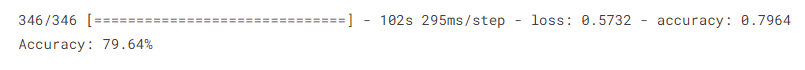

Посмотрим график обучения.

In [ ]:
plot_history(history)

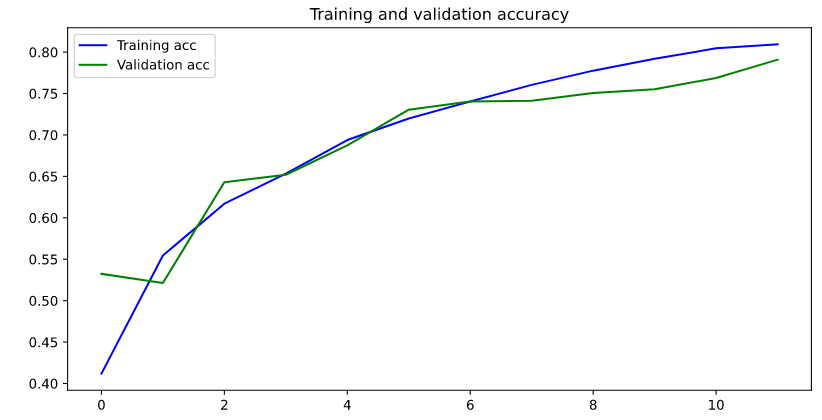

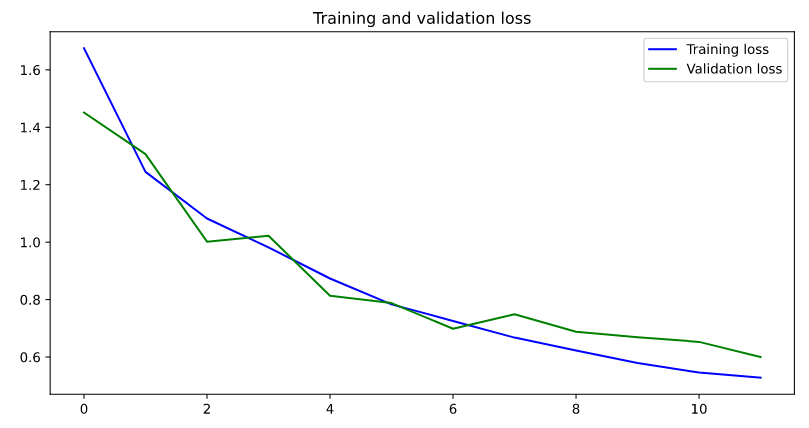

На данном этапе модель уже показывает хорошие результаты.

In [ ]:
# raise KeyboardInterrupt

### Этап 2.  
Обучаем половину слоёв.

In [ ]:
LR=0.0001

In [ ]:
# Раскомментировать при обрыве обучения
# XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step1.hdf5'))
# XC_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])


Разморозим половину слоёв.

In [ ]:
base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

XC_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


Обучаем.

In [ ]:
history = fit_model(XC_model, callbacks_list)

In [ ]:
if is_colab:
    XC_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    XC_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    XC_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    XC_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

In [ ]:
scores = XC_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

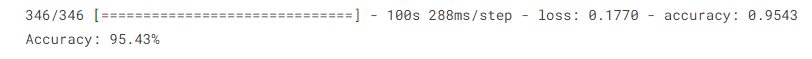

In [ ]:
plot_history(history)

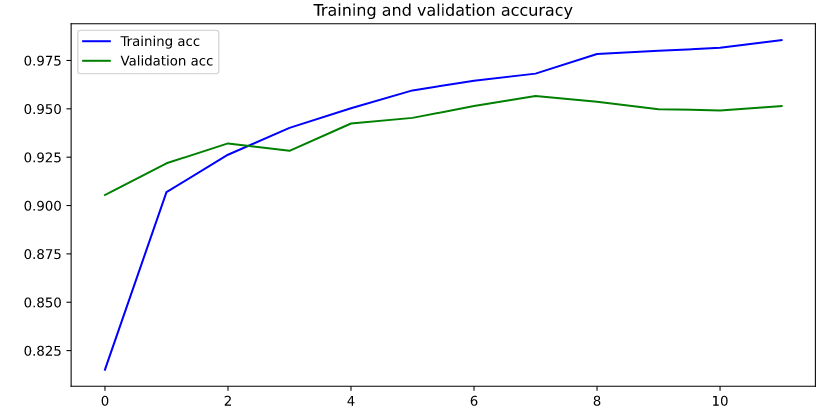

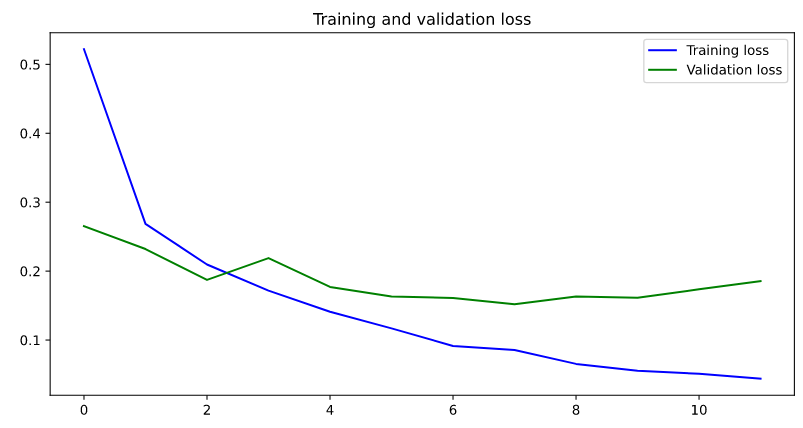

In [ ]:
# raise KeyboardInterrupt

### Этап 3.
Обучаем все слои.

In [ ]:
LR=0.00001

In [ ]:
# Раскомментировать при обрыве обучения
# XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step2.hdf5'))
# XC_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])


In [ ]:
base_model.trainable = True

XC_model.compile(loss="categorical_crossentropy", 
                 optimizer=optimizers.Adam(learning_rate=LR), 
                 metrics=["accuracy"])

In [ ]:
history = fit_model(XC_model, callbacks_list)

In [ ]:
if is_colab:
    XC_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    XC_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    XC_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    XC_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


In [ ]:
XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                      file_name+'_step2.hdf5'))

In [ ]:
scores = XC_model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

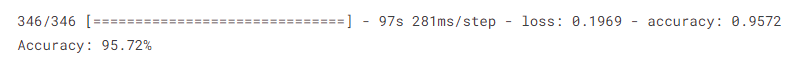

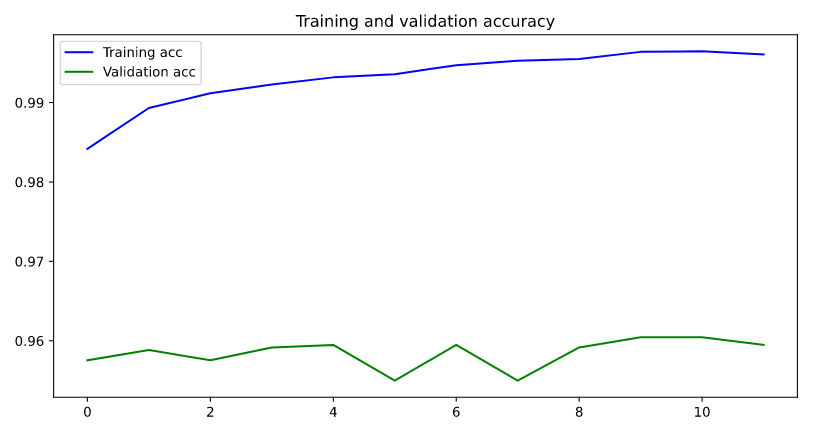

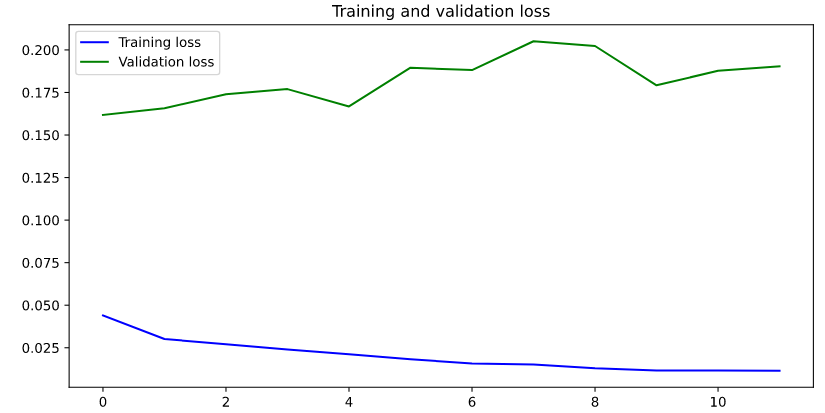

Точность - 95.72%. Loss - 0.1969.  
Данная модель переобучилась, однако всё же показывает неплохой результат.

In [ ]:
# raise KeyboardInterrupt

### Сеть MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=INPUT_SHAPE)

LR=0.001
file_name = 'MNV2_model'

base_model.trainable = False

MNV2_model = get_model(base_model)

MNV2_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR), 
                   metrics=["accuracy"])

if is_colab:
    cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(os.path.join(WORK_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3, 
                             verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]


### Этап 1.

In [ ]:
history = fit_model(MNV2_model, callbacks_list)

if is_colab:
    MNV2_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    MNV2_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    MNV2_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    MNV2_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = MNV2_model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


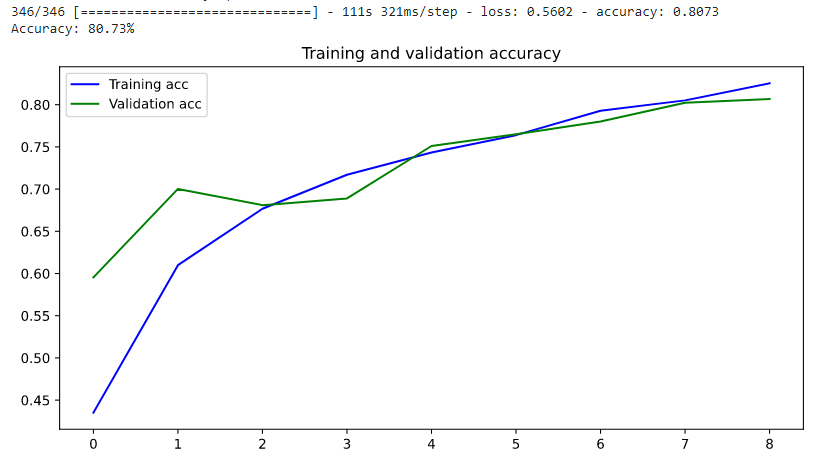

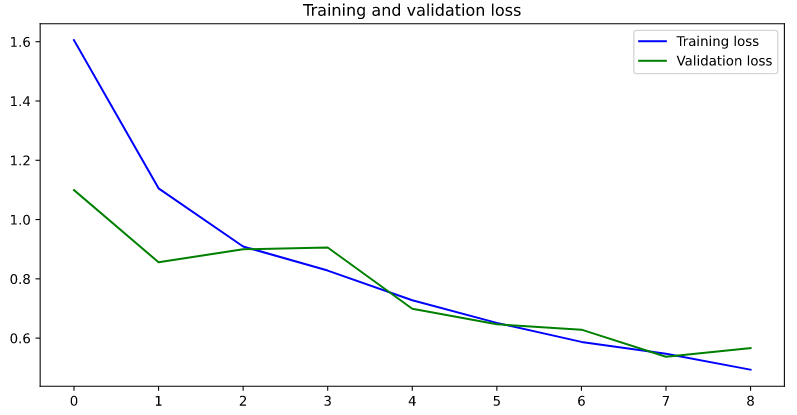

In [ ]:
# raise KeyboardInterrupt

### Этап 2.

In [ ]:
LR=0.0001

################################################################################
# Раскомментировать при обрыве обучения
# MNV2_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step1.hdf5'))
# MNV2_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR), 
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

MNV2_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR), 
                   metrics=["accuracy"])


history = fit_model(MNV2_model, callbacks_list)

if is_colab:
    MNV2_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    MNV2_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    MNV2_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    MNV2_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = MNV2_model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

 

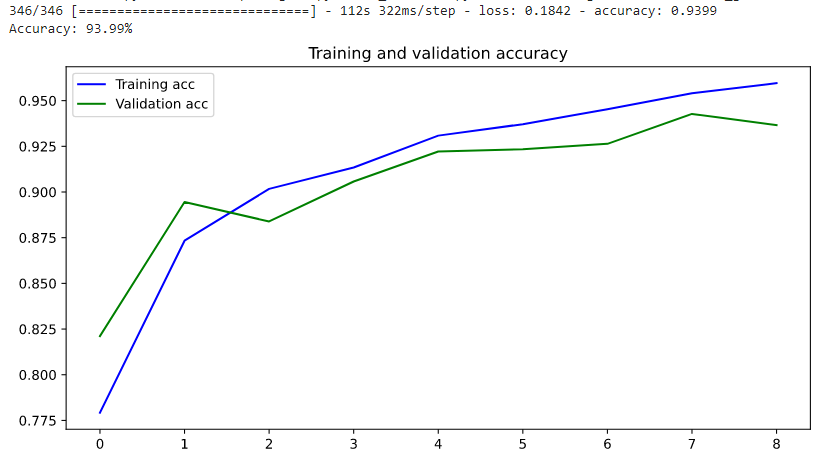

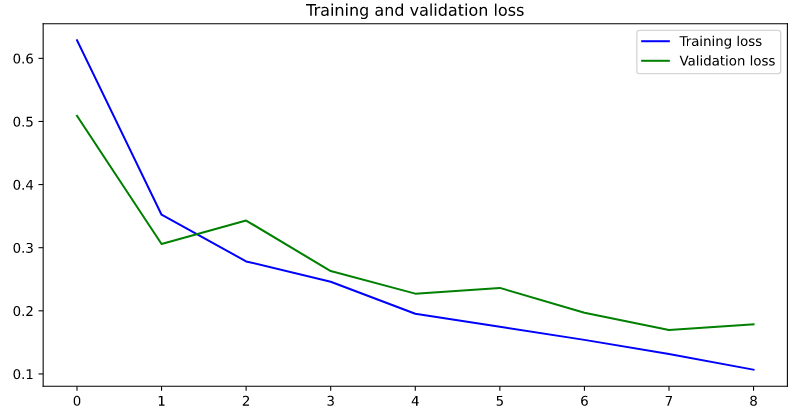

### Этап 3.

In [ ]:
LR=0.00001

################################################################################
# # Раскомментировать при обрыве обучения
# MNV2_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step2.hdf5'))
# MNV2_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR), 
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

MNV2_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR), 
                   metrics=["accuracy"])


history = fit_model(MNV2_model, callbacks_list, epochs=12)

if is_colab:
    MNV2_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    MNV2_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    MNV2_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    MNV2_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = MNV2_model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


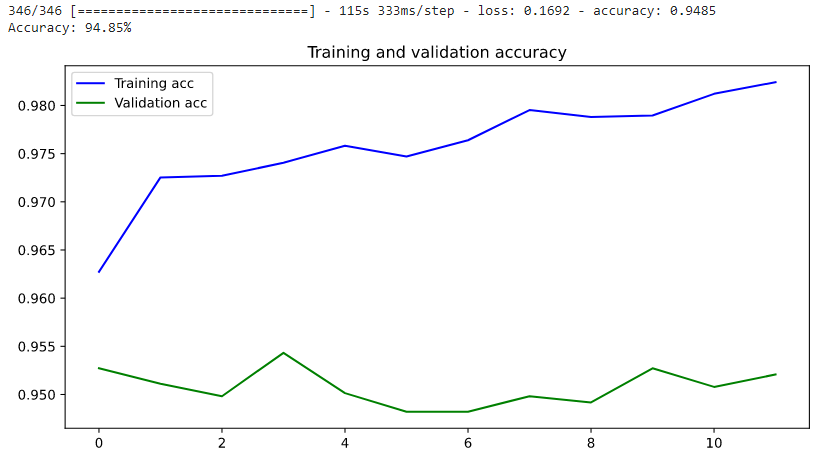

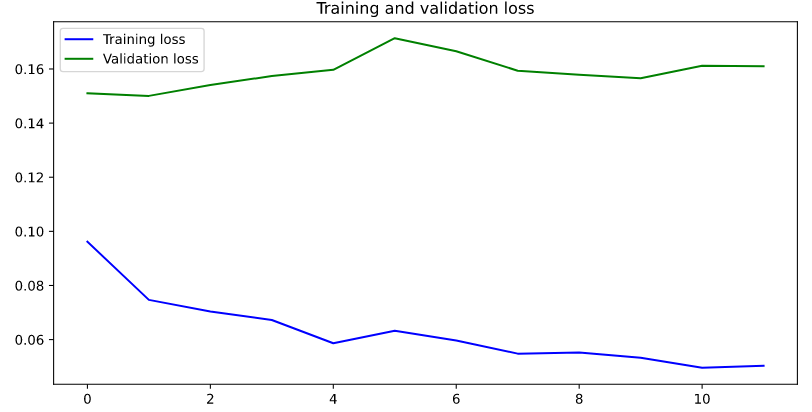

Точность - 94.85%. Loss - 0.1692.

In [ ]:
# raise KeyboardInterrupt

### Сеть NASNetLarge

In [ ]:
LR=0.001

file_name = 'NASNL_model'

base_model = tf.keras.applications.NASNetLarge(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

NASNL_model = get_model(base_model)

NASNL_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

if is_colab:
    cb_checkpoint = ModelCheckpoint(
        os.path.join(SAVE_PATH, file_name+'_best.hdf5'), 
        monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(
        os.path.join(WORK_PATH, file_name+'_best.hdf5'),
         monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3,
                             verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]


In [ ]:
# raise KeyboardInterrupt

### Этап 1.

In [ ]:
history = fit_model(NASNL_model, callbacks_list)

if is_colab:
    NASNL_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    NASNL_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    NASNL_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    NASNL_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


scores = NASNL_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


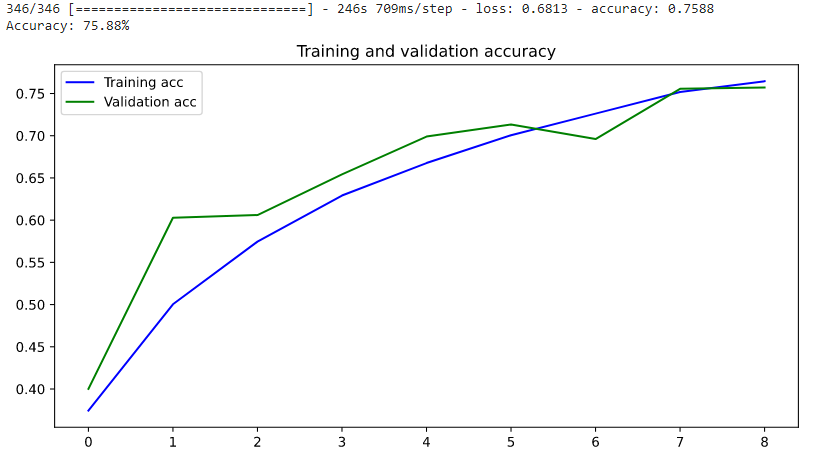

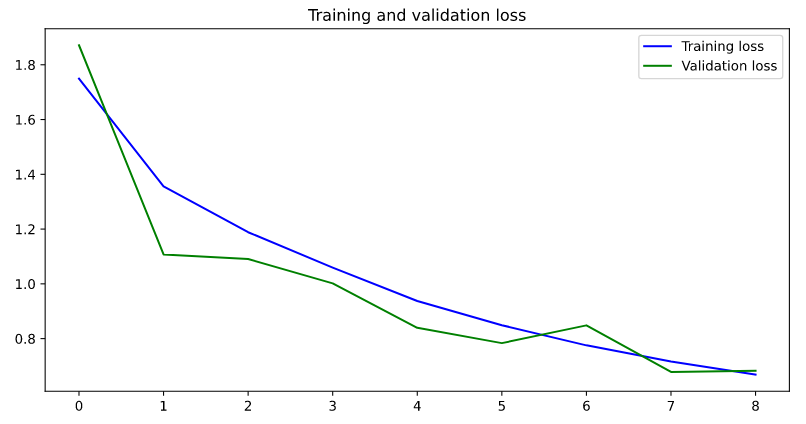

In [ ]:
# raise KeyboardInterrupt

### Этап 2.

In [ ]:
LR=0.0001

################################################################################
# # Раскомментировать при обрыве обучения
# NASNL_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                        file_name+'_step1.hdf5'))

# NASNL_model.compile(loss="categorical_crossentropy", 
#                     optimizer=optimizers.Adam(learning_rate=LR), 
#                     metrics=["accuracy"])
################################################################################

base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

NASNL_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(NASNL_model, callbacks_list)

if is_colab:
    NASNL_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    NASNL_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    NASNL_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    NASNL_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = NASNL_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

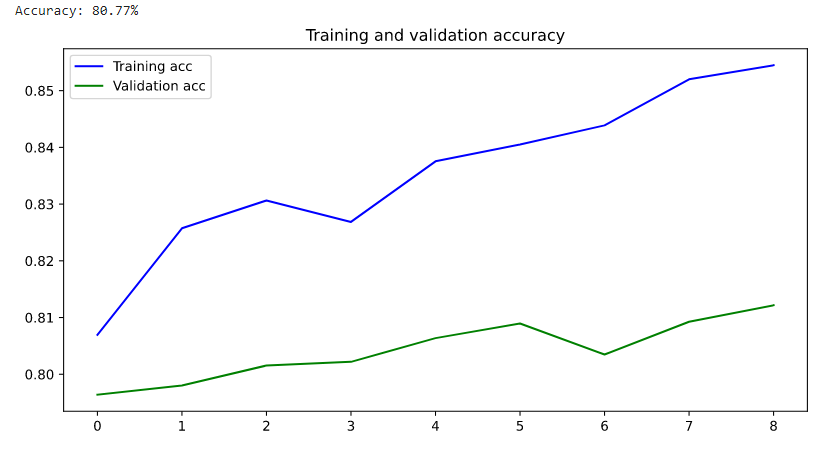

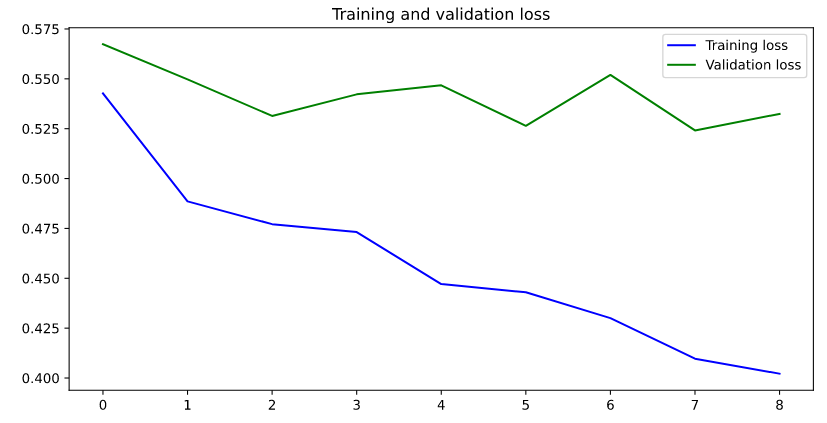

In [ ]:
# raise KeyboardInterrupt

### Этап 3

In [ ]:
LR=0.00001

################################################################################
# # Раскомментировать при обрыве обучения
# NASNL_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step2.hdf5'))
#
# NASNL_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

NASNL_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(NASNL_model, callbacks_list, epochs=12)

if is_colab:
    NASNL_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    NASNL_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    NASNL_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    NASNL_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = NASNL_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

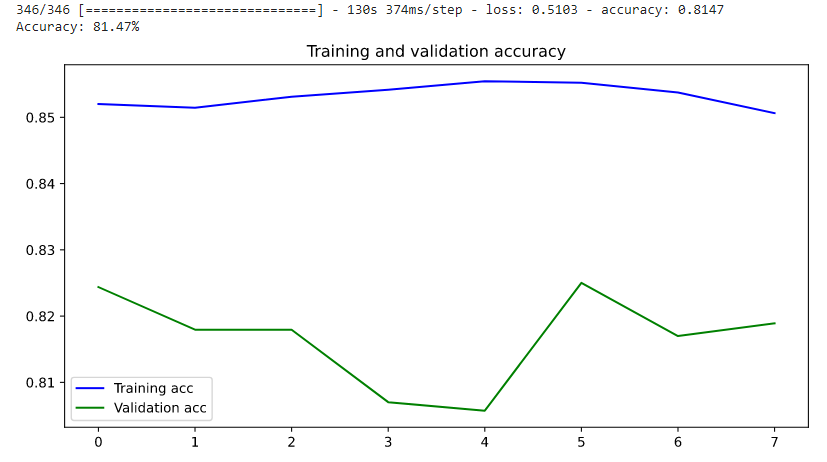

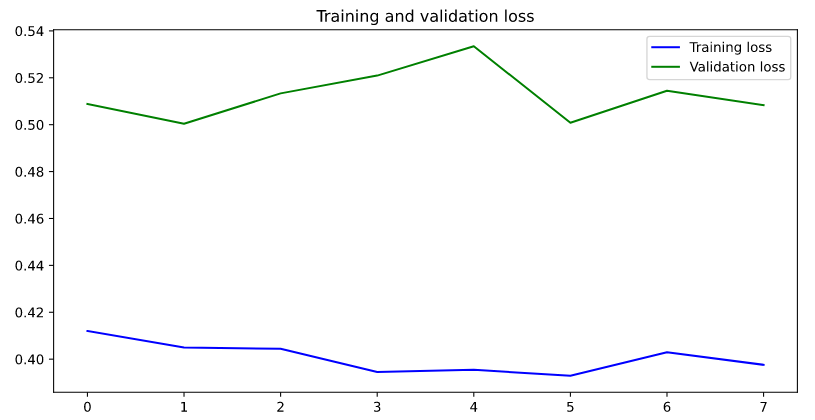

Точность - 81,47%. Loss - 0,5103.  
Данная модель справилась с этой задачей хуже всех. Возможно для неё нужна более серьёзная аугментация, возможно нужно больше эпох и этапов разблокировки слоёв. Возможно нужно больше данных.

In [ ]:
# raise KeyboardInterrupt

### Сеть DenseNet201

In [ ]:
LR=0.001

file_name = 'DN201_model'

base_model = tf.keras.applications.DenseNet201(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=INPUT_SHAPE)

DN201_model = get_model(base_model)

base_model.trainable = False

DN201_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR), 
                    metrics=["accuracy"])

if is_colab:
    cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(os.path.join(WORK_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3, verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]


In [ ]:
# raise KeyboardInterrupt

### Этап 1

In [ ]:
history = fit_model(DN201_model, callbacks_list)

if is_colab:
    DN201_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    DN201_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    DN201_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    DN201_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


scores = DN201_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


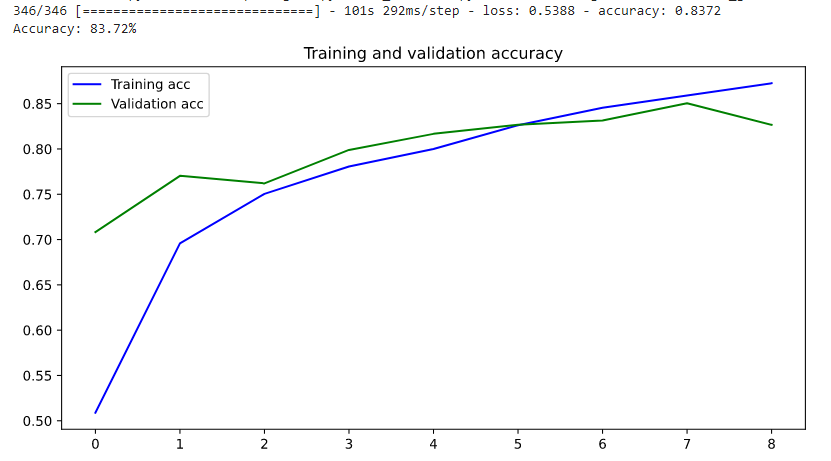

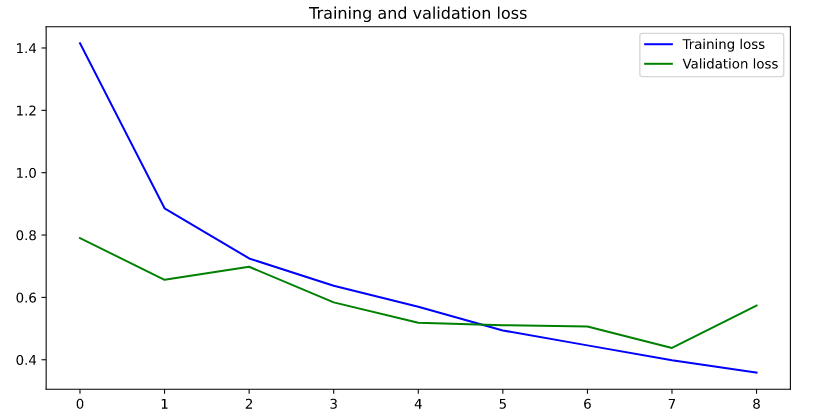

In [ ]:
# raise KeyboardInterrupt

### Этап 2

In [ ]:
LR=0.0001

################################################################################
# # Раскомментировать при обрыве обучения
# DN201_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                      file_name+'_step1.hdf5'))
#
# DN201_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


DN201_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(DN201_model, callbacks_list)

if is_colab:
    DN201_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    DN201_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    DN201_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    DN201_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = DN201_model.evaluate_generator(test_generator, verbose=1)

print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

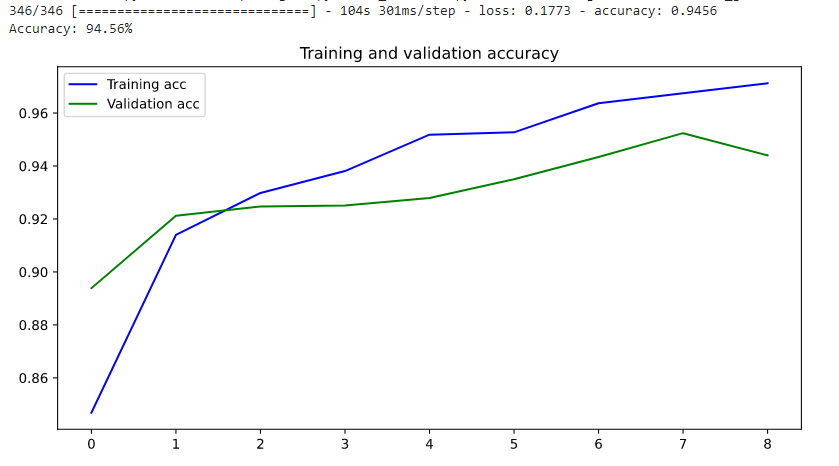

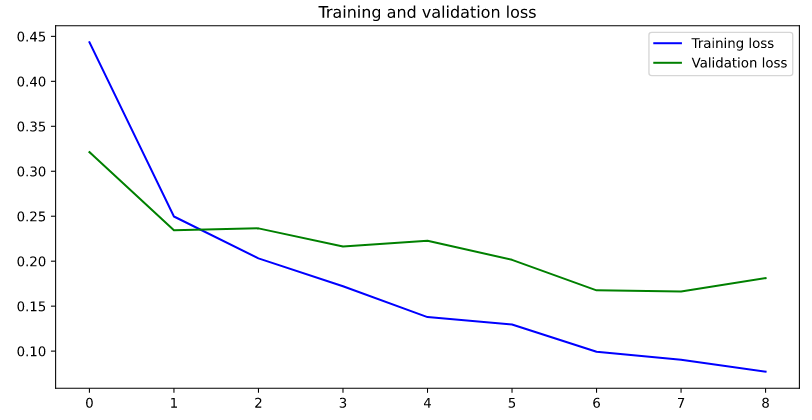

In [ ]:
# raise KeyboardInterrupt

### Этап 3

In [ ]:
LR=0.00001

###############################################################################
# Раскомментировать при обрыве обучения
DN201_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       file_name+'_step2.hdf5'))
DN201_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

DN201_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(DN201_model, callbacks_list, epochs=12)

if is_colab:
    DN201_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    DN201_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    DN201_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    DN201_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = DN201_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

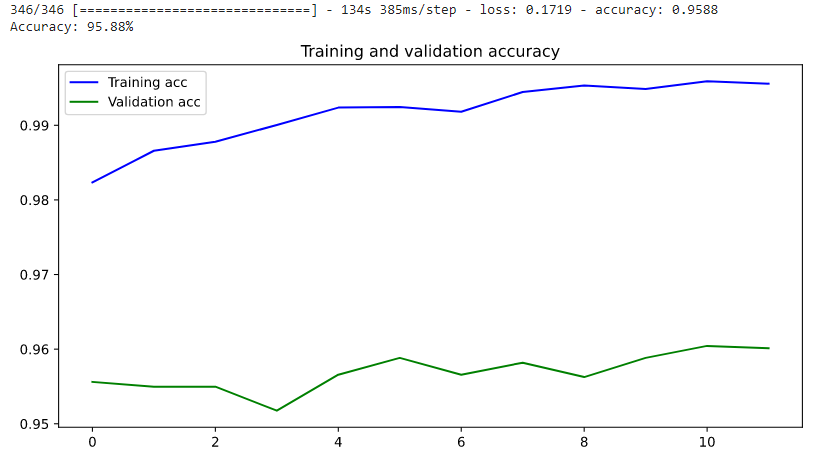

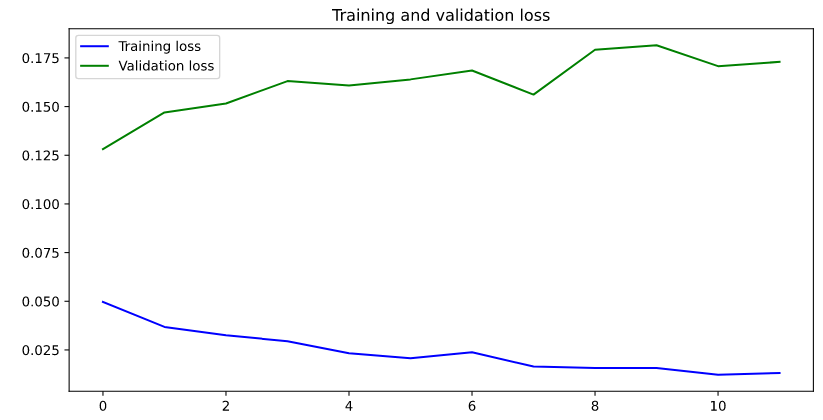

Точность 95.88%, Loss - 0.1719.  

In [ ]:
# raise KeyboardInterrupt

3 из 4 рассмотренных моделей показали хорошие результаты:  
DenseNet201 - 95,88%  
Xception - 95,72%  
MobileNetV2 - 94,85%  

В качестве итоговой модели возмём все три, проделаем TTA и ансамблируем предсказания.

In [ ]:
# Подгрузить рабочую модель
if is_colab:
    DN201_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       'DN201_model_best.hdf5'))

    XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       'XC_model_best.hdf5'))

    MNV2_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       'MNV2_model_best.hdf5'))
else:
    DN201_model = keras.models.load_model(os.path.join(WORK_PATH, 
                                                       'DN201_model_best.hdf5'))

    XC_model = keras.models.load_model(os.path.join(WORK_PATH, 
                                                       'XC_model_best.hdf5'))

    MNV2_model = keras.models.load_model(os.path.join(WORK_PATH, 
                                                       'MNV2_model_best.hdf5'))


# TTA

Прогоним несколько раз картинки через каждую сеть, каждый раз меняя аугментацию и возьмём среднее предсказание.

In [ ]:
sub_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2)
)

sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=test_path,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

DenseNet201

In [ ]:
predictions = []
for _ in range(12):
  predictions.append(DN201_model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)

DN201_model_predictions = predictions.mean(axis=0)


Xception

In [ ]:
predictions = []
for _ in range(12):
  predictions.append(XC_model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)

XC_model_predictions = predictions.mean(axis=0)

MobileNetV2

In [ ]:
predictions = []
for _ in range(12):
  predictions.append(MNV2_model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)

MNV2_model_predictions = predictions.mean(axis=0)

# Ансамблирование

Посчитаем средневзвешенное среднее предсказаний моделей, отдав больший вес той модели, которая имеет более высокую точность.

In [ ]:
final_prediction = 0.45*DN201_model_predictions \
                 + 0.4*XC_model_predictions \
                 + 0.15*MNV2_model_predictions

final_prediction = final_prediction.argmax(axis=1)

In [ ]:
len(final_prediction)

# Submission

In [ ]:
filenames_with_dir=sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 
                           'Category':final_prediction})
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.head(10)

In [ ]:
if is_colab:
    submission.to_csv(os.path.join(SAVE_PATH, 'car_classif_submission.csv'), 
                  index=False)
else:
    submission.to_csv(os.path.join(WORK_PATH, 'car_classif_submission.csv'), 
                  index=False)

# Итоги

В качестве подопытных были выбраны следующие модели:  
Xception, MobileNetV2, NASNetLarge, DenseNet201, EfficientNetV2, EfficientNetB6, EfficientNetB7.  
Три последние были исключены из работы по причине неподходящей архитектуры.

В ходе работы был на практике изучен процесс решения задачи классификации изображений с помощью нейронных сетей, основанных на предобученных общедоступных сетях, использующих датасет ImageNet.

Для более качественных результатов стоит прибегнуть к реализации более продвинутой аугментации изображений, а так же попробовать реализовать ансамблевый классификатор, оперирующий базовыми моделями. А так же стоит уделить время на сбор дополнительных данных.

В ходе работы я столкнулся с проблемой, когда рассматриваемые модели просто не обучалась выше 12,5% точности. По всей видимости, я выбирал модели неподходящей архитектуры из-за чего было упущено много времени и не получилось реализовать вышеописанное.

Не смотря на всё как минимум, работа позволила получить необходимый опыт и знания.
